In [1]:
# Reference
# https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py
# https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data.dataset import Dataset

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

import numpy as np

import PIL
from PIL import Image

import pickle

from pprint import pprint

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np

In [3]:
########################################################################
# Okay, so what next?
#
# How do we run these neural networks on the GPU?
#
# Training on GPU
# ----------------
# Just like how you transfer a Tensor on to the GPU, you transfer the neural
# net onto the GPU.
#
# Let's first define our device as the first visible cuda device if we have
# CUDA available:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
data = unpickle('./curriculum_clustering/input/webvision_cls0-9_batch1')
X = data['images']
img_ids = data['id']
id_to_img = dict()
for i, img_id in enumerate(img_ids):
    id_to_img[img_id] = X[i]

data = unpickle('./curriculum_clustering/input/webvision_cls0-9_batch2')
X = data['images']
img_ids = data['id']
for i, img_id in enumerate(img_ids):
    id_to_img[img_id] = X[i]

print("# img_ids:", len(id_to_img))

# img_ids: 13720


In [4]:
data_val = unpickle('./curriculum_clustering/input/webvision_cls0-9_val')

print("# img_ids_val:", len(data_val['id']))

# img_ids_val: 500


In [5]:
########################################################################
# Custom dataset
# 

class WebvisionDataset(Dataset):
    def __init__(self, id_to_img, num_cluster=3, combine=True, transform=None):
        
        def getCluster(cluster_set, file):
            with open(file) as f:
                metadata_cluster = [x.strip().split(' ') for x in f]

            return cluster_set.union(set([item[0] for item in metadata_cluster]))
            
        cluster_txt = ["1.txt", "2.txt", "3.txt"]
        
        cluster_list = './curriculum_clustering/input/webvision_cls0-9.txt' # webvision train list
        with open(cluster_list) as f:
            metadata = [x.strip().split(' ') for x in f]
        
        metadata_cluster_set = set()
        if combine:
            for i in range(num_cluster):
                cluster = './curriculum_clustering/output-expected-webvision/' + cluster_txt[i]
                metadata_cluster_set = getCluster(metadata_cluster_set, cluster)
        else:
            cluster = './curriculum_clustering/output-expected-webvision/' + cluster_txt[num_cluster-1]
            metadata_cluster_set = getCluster(metadata_cluster_set, cluster)

        X_train = []
        y_train = []
        metadata_train = []
        for i, data in enumerate(metadata):
            file = data[0]
            y = data[1]
            if file in metadata_cluster_set:
                img = id_to_img.get(file, None)
                if img is not None:
                    X_train.append(img)
                    y_train.append(y)
                    metadata_train.append(data)
           
        self.X_train = X_train
        self.y_train = y_train
        self.metadata_train = metadata
        
        print("# X_train:", len(self.X_train))
        print("# y_train:", len(self.y_train))
        for i in range(0,10):
            target = str(i)
            print("% "+target, len([x for x in self.y_train if x==target])/len(self.y_train))
        print()
        self.transform = transform
        
    def __getitem__(self, index):
        img = self.X_train[index]
        img = Image.fromarray(np.uint8(img))
        if self.transform is not None:
            img = self.transform(img)
        
        label = int(self.y_train[index])
        return img, label

    def __len__(self):
        return len(self.X_train)

In [6]:
########################################################################
# Custom dataset
# 

class WebvisionDatasetVal(Dataset):
    def __init__(self, data_val, train=False, transform=None):          
        self.X_test = data_val['images']
        self.y_test = data_val['classes']
        self.metadata_test = data_val['id']
        
        print("# X_test:", len(self.X_test))
        print("# y_test:", len(self.y_test))
        for i in range(0,10):
            target = str(i)
            print("% "+target, len([x for x in self.y_test if x==target])/len(self.y_test))
        print()
        self.transform = transform
        self.train = train
        
    def __getitem__(self, index):
        img = self.X_test[index]
        img = Image.fromarray(np.uint8(img))
        if self.transform is not None:
            img = self.transform(img)
        
        label = int(self.y_test[index])
        return img, label

    def __len__(self):
        return len(self.X_test)

In [26]:
transform = transforms.Compose(
    [
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transform_reg = transforms.Compose(
    [
     transforms.Resize((224, 224)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(224, padding=4),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

wv1 = WebvisionDataset(id_to_img, num_cluster=1, transform=transform)
wv2 = WebvisionDataset(id_to_img, num_cluster=2, transform=transform)
wv3 = WebvisionDataset(id_to_img, num_cluster=3, transform=transform)
wv_val = WebvisionDatasetVal(data_val, train=False, transform=transform)

# wv1 = WebvisionDataset(id_to_img, num_cluster=1, transform=transform_reg)
# wv2 = WebvisionDataset(id_to_img, num_cluster=2, transform=transform_reg)
# wv3 = WebvisionDataset(id_to_img, num_cluster=3, transform=transform_reg)
# wv3_reg = WebvisionDataset(id_to_img, num_cluster=3, transform=transform_reg)
# wv_val = WebvisionDatasetVal(data_val, train=False, transform=transform)

# X_train: 7101
# y_train: 7101
% 0 0.05858329812702436
% 1 0.11758907196169553
% 2 0.09238135473876918
% 3 0.11139276158287566
% 4 0.10646387832699619
% 5 0.11223771299816927
% 6 0.09195887903112238
% 7 0.09956344176876496
% 8 0.09660611181523729
% 9 0.11322348964934516

# X_train: 11619
# y_train: 11619
% 0 0.10431190291763491
% 1 0.0979430243566572
% 2 0.09923401325415268
% 3 0.10121352956364575
% 4 0.09888974954815388
% 5 0.10198812290214304
% 6 0.0973405628711593
% 7 0.09863155176865479
% 8 0.09966434288665117
% 9 0.10078319993114726

# X_train: 13720
# y_train: 13720
% 0 0.1
% 1 0.1
% 2 0.1
% 3 0.1
% 4 0.1
% 5 0.1
% 6 0.1
% 7 0.1
% 8 0.1
% 9 0.1

# X_test: 500
# y_test: 500
% 0 0.1
% 1 0.1
% 2 0.1
% 3 0.1
% 4 0.1
% 5 0.1
% 6 0.1
% 7 0.1
% 8 0.1
% 9 0.1



In [27]:
########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].

trainloader_viewer = torch.utils.data.DataLoader(wv3, batch_size=4,
                                          shuffle=True, num_workers=0)

trainloader1 = torch.utils.data.DataLoader(wv1, batch_size=32,
                                          shuffle=True, num_workers=0)

trainloader2 = torch.utils.data.DataLoader(wv2, batch_size=32,
                                          shuffle=True, num_workers=0)

trainloader3 = torch.utils.data.DataLoader(wv3, batch_size=32,
                                          shuffle=True, num_workers=0)

#trainloader3_reg = torch.utils.data.DataLoader(wv3_reg, batch_size=32,
#                                          shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(wv_val, batch_size=4,
                                          shuffle=False, num_workers=0)


classes = ('tench', 'goldfish', 'great_white_shark', 'tiger_shark',
           'hammerhead_shark', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich')

In [28]:
########################################################################
# Let us show some of the training images, for fun.

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ostrich tiger_shark tiger_shark hammerhead_shark


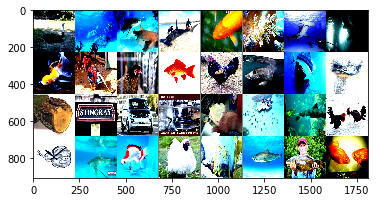

In [29]:
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [30]:
# ########################################################################
# # 2. Define a Convolution Neural Network

net = models.squeezenet1_1(pretrained=True)
#net = models.resnet18(pretrained=True)
#net.to(device)

C:\Users\Sophie\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
C:\Users\Sophie\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


In [31]:
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [32]:
def train(epoch, trainloader):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    every = 10
    total_train_loss = 0
    cnt = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        #inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_train_loss += loss.item()
        cnt += 1
        
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % every == (every-1):    # print every x mini-batches
            print('[%d, %5d] Loss: %.3f'
            % (epoch, batch_idx, train_loss/(batch_idx+1)))
    
    print('Train Acc: %.3f%% (%d/%d)'
                % (100.*correct/total, correct, total))
    
    total_loss = total_train_loss/cnt
    total_acc = correct/total
    return total_loss, total_acc

In [33]:
def test(epoch, testloader):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    total_test_loss = 0
    cnt = 0
    every = 10
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            #inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            total_test_loss += loss.item()
            cnt += 1
            
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            if batch_idx % every == (every-1):    # print every x mini-batches
                print('[%d, %5d] Loss: %.3f'
                % (epoch, batch_idx, test_loss/(batch_idx+1)))
    
        
        print('Test Acc: %.3f%% (%d/%d)'
                    % (100.*correct/total, correct, total))
    
    total_loss = total_test_loss/cnt
    total_acc = correct/total
    return total_loss, total_acc

In [34]:
def plotLoss(epoch, filename):
    #plt.figure(figsize=(10, 8))
    plt.plot(tr_losses, label='Train')
    plt.plot(te_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./images/'+filename+'_loss.png')
    plt.close()

In [35]:
def plotAcc(epoch, filename):
    #plt.figure(figsize=(10, 8))
    plt.plot(tr_accs, label='Train')
    plt.plot(te_accs, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('./images/'+filename+'_acc.png')
    plt.close()

In [36]:
########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize.

cluster_experiment=False
reg_experiment=False

loaders = []
if cluster_experiment:
    loaders = [trainloader1, trainloader2, trainloader3]
else:
    if reg_experiment:
        loaders = [trainloader3_reg]
    else:
        loaders = [trainloader3]

tr_losses = []
te_losses = []
tr_accs = []
te_accs = []
modelname = 'webvision-squeezenet1_1-pretrained'
#modelname = 'webvision-resnet18'
for it, trainloader in enumerate(loaders):
    print("*** Cluster:", it+1)
    print("# loaders:", len(loaders))
    for epoch in range(30):  # loop over the dataset multiple times
        epoch+=1
        tr_loss, tr_acc = train(epoch, trainloader)
        te_loss, te_acc = test(epoch, testloader)
        tr_losses.append(tr_loss)
        te_losses.append(te_loss)
        tr_accs.append(tr_acc)
        te_accs.append(te_acc)

        every_epoch = 1
        if i % every_epoch == (every_epoch-1):    # save every x epochs
            print("save")
            if cluster_experiment:
                filename = modelname+'-loader'+str(it+1)+'_epoch'+str(epoch)
            else:
                if reg_experiment:
                    filename = modelname+'-loader-all-reg_epoch'+str(epoch)
                else:
                    filename = modelname+'-loader-all_epoch'+str(epoch)
            
            # save model
            torch.save(net, './zoo/'+filename+'.pth.tar')
            
            # save plot loss and acc
            plotLoss(epoch, filename)
            plotAcc(epoch, filename)
            
print('Finished Training')

*** Cluster: 1
# loaders: 1

Epoch: 1
[1,     9] Loss: 3.015
[1,    19] Loss: 2.456
[1,    29] Loss: 2.198
[1,    39] Loss: 2.046
[1,    49] Loss: 1.932
[1,    59] Loss: 1.841
[1,    69] Loss: 1.790
[1,    79] Loss: 1.721
[1,    89] Loss: 1.670
[1,    99] Loss: 1.631
[1,   109] Loss: 1.587
[1,   119] Loss: 1.563
[1,   129] Loss: 1.533
[1,   139] Loss: 1.503
[1,   149] Loss: 1.490
[1,   159] Loss: 1.473
[1,   169] Loss: 1.451
[1,   179] Loss: 1.435
[1,   189] Loss: 1.422
[1,   199] Loss: 1.407
[1,   209] Loss: 1.391
[1,   219] Loss: 1.382
[1,   229] Loss: 1.370
[1,   239] Loss: 1.361
[1,   249] Loss: 1.349
[1,   259] Loss: 1.341
[1,   269] Loss: 1.328
[1,   279] Loss: 1.322
[1,   289] Loss: 1.316
[1,   299] Loss: 1.308
[1,   309] Loss: 1.300
[1,   319] Loss: 1.289
[1,   329] Loss: 1.285
[1,   339] Loss: 1.284
[1,   349] Loss: 1.279
[1,   359] Loss: 1.275
[1,   369] Loss: 1.273
[1,   379] Loss: 1.265
[1,   389] Loss: 1.262
[1,   399] Loss: 1.258
[1,   409] Loss: 1.257
[1,   419] Loss: 1.

[13,   149] Loss: 0.419
[13,   159] Loss: 0.416
[13,   169] Loss: 0.415
[13,   179] Loss: 0.413
[13,   189] Loss: 0.412
[13,   199] Loss: 0.416
[13,   209] Loss: 0.416
[13,   219] Loss: 0.411
[13,   229] Loss: 0.416
[13,   239] Loss: 0.419
[13,   249] Loss: 0.423
[13,   259] Loss: 0.427
[13,   269] Loss: 0.427
[13,   279] Loss: 0.427
[13,   289] Loss: 0.427
[13,   299] Loss: 0.429
[13,   309] Loss: 0.429
[13,   319] Loss: 0.428
[13,   329] Loss: 0.428
[13,   339] Loss: 0.429
[13,   349] Loss: 0.426
[13,   359] Loss: 0.426
[13,   369] Loss: 0.425
[13,   379] Loss: 0.427
[13,   389] Loss: 0.430
[13,   399] Loss: 0.433
[13,   409] Loss: 0.434
[13,   419] Loss: 0.434
Train Acc: 84.621% (11610/13720)
[13,     9] Loss: 0.868
[13,    19] Loss: 0.614
[13,    29] Loss: 0.565
[13,    39] Loss: 0.579
[13,    49] Loss: 0.593
[13,    59] Loss: 0.672
[13,    69] Loss: 0.759
[13,    79] Loss: 0.813
[13,    89] Loss: 0.789
[13,    99] Loss: 0.778
[13,   109] Loss: 0.750
[13,   119] Loss: 0.711
Test Ac

[25,   109] Loss: 0.161
[25,   119] Loss: 0.165
[25,   129] Loss: 0.171
[25,   139] Loss: 0.173
[25,   149] Loss: 0.176
[25,   159] Loss: 0.180
[25,   169] Loss: 0.179
[25,   179] Loss: 0.183
[25,   189] Loss: 0.185
[25,   199] Loss: 0.183
[25,   209] Loss: 0.180
[25,   219] Loss: 0.180
[25,   229] Loss: 0.180
[25,   239] Loss: 0.179
[25,   249] Loss: 0.178
[25,   259] Loss: 0.178
[25,   269] Loss: 0.181
[25,   279] Loss: 0.183
[25,   289] Loss: 0.184
[25,   299] Loss: 0.186
[25,   309] Loss: 0.188
[25,   319] Loss: 0.189
[25,   329] Loss: 0.193
[25,   339] Loss: 0.194
[25,   349] Loss: 0.194
[25,   359] Loss: 0.194
[25,   369] Loss: 0.194
[25,   379] Loss: 0.194
[25,   389] Loss: 0.194
[25,   399] Loss: 0.192
[25,   409] Loss: 0.192
[25,   419] Loss: 0.193
Train Acc: 93.367% (12810/13720)
[25,     9] Loss: 0.909
[25,    19] Loss: 0.616
[25,    29] Loss: 0.753
[25,    39] Loss: 0.769
[25,    49] Loss: 0.758
[25,    59] Loss: 0.782
[25,    69] Loss: 0.809
[25,    79] Loss: 0.913
[25,   

In [37]:
# save losses
history = dict()
history['tr_loss'] = tr_losses
history['te_loss'] = te_losses
history['tr_acc'] = tr_accs
history['te_acc'] = te_accs
with open("./history/" + modelname + "_history", "w", encoding='utf-8') as fout:
    pprint(history, fout)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  tiger_shark goldfish goldfish tiger_shark


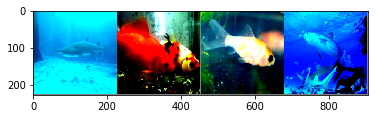

In [76]:
########################################################################
# 5. Test the network on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# We have trained the network for 2 passes over the training dataset.
# But we need to check if the network has learnt anything at all.
#
# We will check this by predicting the class label that the neural network
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

dataiter = iter(trainloader_viewer)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [77]:
########################################################################
# Okay, now let us see what the neural network thinks these examples above are:

outputs = net(images)

In [78]:
########################################################################
# The outputs are energies for the 10 classes.
# Higher the energy for a class, the more the network
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  tiger_shark goldfish tiger_shark tiger_shark


In [38]:
# confusion matrix
nb_classes = 10

conf_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        #inputs = inputs.to(device)
        #classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
            conf_matrix[t.long(), p.long()] += 1

print(conf_matrix)

tensor([[41.,  2.,  1.,  1.,  2.,  2.,  0.,  0.,  1.,  0.],
        [ 0., 50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 3.,  0., 38.,  4.,  3.,  1.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  1., 38.,  7.,  2.,  1.,  0.,  1.,  0.],
        [ 0.,  0.,  2.,  8., 38.,  1.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  3.,  2., 37.,  6.,  0.,  1.,  0.],
        [ 1.,  0.,  2.,  2.,  5.,  5., 35.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0., 38., 11.,  0.],
        [ 0.,  1.,  0.,  0.,  1.,  0.,  1., 12., 35.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  3.,  0., 46.]])


In [39]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

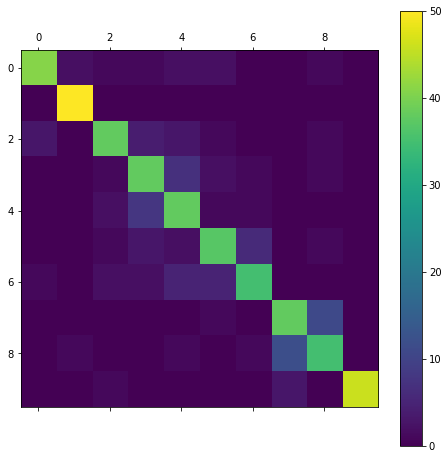

In [40]:
conf_mx_test = conf_matrix.numpy()
#row_sums = conf_mx_test.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx_test
#np.fill_diagonal(norm_conf_mx, 0)
# plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plot_confusion_matrix(norm_conf_mx)
plt.show()

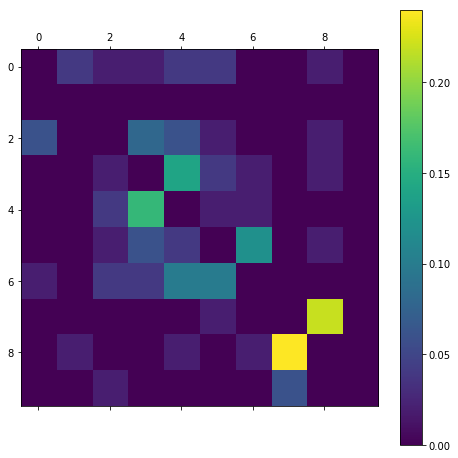

In [41]:
conf_mx_test = conf_matrix.numpy()
row_sums = conf_mx_test.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx_test / row_sums
np.fill_diagonal(norm_conf_mx, 0)
# plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plot_confusion_matrix(norm_conf_mx)
plt.show()

In [30]:
########################################################################
# The results seem pretty good.
#
# Let us look at how the network performs on the whole dataset.

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [24]:
########################################################################
# That looks waaay better than chance, which is 10% accuracy (randomly picking
# a class out of 10 classes).
# Seems like the network learnt something.
#
# Hmmm, what are the classes that performed well, and the classes that did
# not perform well:

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        #print(labels)
        #print(c)
        #break
        for i in range(0,len(labels)):
            label = labels[i].item()
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    total = class_total[i]
    if total == 0:
        total = 1
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / total))

Accuracy of tench : 62 %
Accuracy of goldfish : 98 %
Accuracy of great_white_shark : 46 %
Accuracy of tiger_shark : 62 %
Accuracy of hammerhead_shark : 50 %
Accuracy of electric_ray : 24 %
Accuracy of stingray : 38 %
Accuracy of  cock : 58 %
Accuracy of   hen : 40 %
Accuracy of ostrich : 80 %


In [84]:
torch.save(net, './zoo/webvision-squeezenet1_1-test.pth.tar')

In [6]:
resnet18 = models.resnet18(pretrained=True)

torch.save(resnet18, './zoo/imagenet-resnet18.pth.tar')